In [ ]:
import os
from langchain_openai import AzureOpenAIEmbeddings
from langchain.embeddings import (
    HuggingFaceEmbeddings,
)
embeddings = HuggingFaceEmbeddings(
                model_name="BAAI/bge-large-en-v1.5",
                # model_kwargs={'device': 'cpu'},
                encode_kwargs={'normalize_embeddings': False},
            )
from langchain.storage import LocalFileStore, RedisStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_community.vectorstores import FAISS
store = RedisStore(redis_url="redis://localhost:6379")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
embeddings, store, namespace="bge-large"
)
row_string = []
with open('./data/clean_relations', 'r') as f:
    r_data = [line.strip() for line in f]
all_db = FAISS.from_texts(r_data, cached_embedder)

/tmp/ipykernel_1736929/2109291646.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/media/disk1/chatgpt/miniconda3/envs/self-rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Run_long_form answer

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
model = LLM(model='/media/disk2/llama_factory/generation_0202_uti_no_mask', trust_remote_code=True, tensor_parallel_size=1)
tokenizer = AutoTokenizer.from_pretrained('/media/disk2/llama_factory/generation_0202_uti_no_mask')
sampling_params = SamplingParams(
            temperature=0.0, top_p=1.0,max_tokens=100, logprobs=10, skip_special_tokens=False, include_stop_str_in_output=True)
PROMPT_DICT = {"llama3": '<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{input}<|eot_id|><|start_header_id|>assistant<|end_header_id|>', "llama2": "<s>[INST] {input} [/INST]"}
test = model.generate([PROMPT_DICT["llama3"].format(input="你好")], sampling_params)[0].outputs[0]

WARNING 05-20 07:17:10 cuda.py:22] You are using a deprecated `pynvml` package. Please install `nvidia-ml-py` instead, and make sure to uninstall `pynvml`. When both of them are installed, `pynvml` will take precedence and cause errors. See https://pypi.org/project/pynvml for more information.


2025-05-20 07:17:10,546	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 05-20 07:17:14 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='/media/disk2/llama_factory/generation_0202_uti_no_mask', speculative_config=None, tokenizer='/media/disk2/llama_factory/generation_0202_uti_no_mask', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=/media/disk2/llama_factory/generation_0202_uti_no_mask, num

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.56it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.59it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.16it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.29it/s]



INFO 05-20 07:17:19 model_runner.py:1067] Loading model weights took 14.9605 GB
INFO 05-20 07:17:20 gpu_executor.py:122] # GPU blocks: 9656, # CPU blocks: 2048
INFO 05-20 07:17:20 gpu_executor.py:126] Maximum concurrency for 8192 tokens per request: 18.86x
INFO 05-20 07:17:21 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-20 07:17:21 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-20 07:17:39 model_runner.py:1523] Graph capturing finished in 18 secs.


In [23]:
def load_special_tokens(tokenizer, use_grounding=False, use_utility=False):
    rel_tokens = {}
    for token in ['[Unrelevant]','[Partially Relevant]','[Fully Relevant]']:
        rel_tokens[token] = tokenizer.convert_tokens_to_ids(token)
    reason_tokens = {}
    for token in ['[Fully Reasonable]', '[Partially Reasonable]', '[Unreasonable]']:
        reason_tokens[token] = tokenizer.convert_tokens_to_ids(token)
    ut_tokens = {}
    for token in ['[Utility:5]','[Utility:4]','[Utility:3]','[Utility:2]','[Utility:1]']:
        ut_tokens[token] = tokenizer.convert_tokens_to_ids(token)

    return rel_tokens, reason_tokens, ut_tokens
rel_tokens, reason_tokens, utility_tokens = load_special_tokens(tokenizer)

In [9]:

import json
with open('/media/disk1/chatgpt/zh/ToG/data/graliqa.json', 'r',encoding='utf-8') as f:
    test_data = json.load(f)
print(len(test_data))

1000


In [5]:
import json
with open('./data/merged/WebQSP_test.json', 'r',encoding='utf-8') as f:
    test_data = json.load(f)
print(len(test_data))

1639


In [4]:
import json
with open('./data/merged/CWQ_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)
print(len(test_data))

3531


In [12]:
from typing import List
import random
def save_to_json(data: List, data_path=''):
    if not os.path.isfile(data_path):
        # 文件不存在，创建新列表并写入文件
        with open(data_path, 'w', encoding='utf-8') as file:
            json.dump(data, file, ensure_ascii=False, indent=4)
        return
    try:
        # 尝试读取现有文件
        with open(data_path, 'r', encoding='utf-8') as file:
            # 加载现有的JSON数据
            existing_data = json.load(file)
            existing_data.extend(data)
    except json.JSONDecodeError:
        # 文件不是有效的JSON，打印错误信息并退出
        print(f"文件 {data_path} 不是有效的JSON格式。")
        return
    except ValueError as e:
        # 打印错误信息并退出
        print(e)
        return
    # 将更新后的数据写回文件
    with open(data_path, 'w', encoding='utf-8') as file:
        json.dump(existing_data, file, ensure_ascii=False, indent=4)
def random_sample(lst, k=3):
    return random.sample(lst, min(k, len(lst)))

In [13]:
import numpy as np
import re
from src.sparql_utils import *
import random
#维护一个relation 池
def run_relation_generation_batch(model, prompt, llama, context, topic_entity, hypo=True, use_1hop=True, income=None):
    # 初始化关系得分字典、最终预测列表、总体得分列表、最终上下文列表、段落集合
    final_preds = []
    overall_scores = []
    final_contexts = []
    paragraph = set()
    # 如果是新检索，则设置检索标记为"[Retrieve Relation]"，否则设置为"[Retrieve Relation]"
    
    retrieval_token = "[Retrieve Relation]"
    # 如果使用1跳关系，则获取1跳关系，否则使用所有关系
    if use_1hop:
        candidate_relations = set()
        for entity in topic_entity:
            try:
                candidate_relations.update(get_1hop_relations_with_odbc(entity))
            except:
                continue
        if len(list(candidate_relations)):
            vec_db = FAISS.from_texts(list(candidate_relations), cached_embedder)
        else:
            vec_db = all_db
        retriever = vec_db.as_retriever(search_kwargs={"k": 10})
    else:
        retriever = all_db.as_retriever(search_kwargs={"k": 10})
    # 获取段落内容
    try:
        if llama == 'llama3':
            paragraph.update([page.page_content.strip() for page in retriever.invoke(prompt.split('\n\n')[1].split('<|eot_id|>')[0] + ' '+ context)])
        else:
            paragraph.update([page.page_content.strip() for page in retriever.invoke(prompt.split('[INST]')[1].split('[/INST]')[0].strip() + ' '+ context)])
    except:
        pass
    # 如果使用假设，则生成假设关系
    if hypo:
        hypo_rel = model.generate(prompt + retrieval_token, sampling_params)[0].outputs[0].text
        pattern = r'(\w+\.\w+\.\w+)\[(.*?)\]'
        if '[Retrieve Entity]' in hypo_rel:
            hypo_rel = hypo_rel.split('[Retrieve Entity]')[0]
        matches =  dict(re.findall(pattern, hypo_rel))
        string = ''
        for k,v in matches.items():
            if v in ['Fully Relevant', 'Partially Relevant']:
                string += k + ' '
        paragraph.update([page.page_content.strip() for page in retriever.invoke(string)])
    paragraph.discard(income)
    aug_prompts =  ["<paragraph>{}</paragraph>".format(';'.join(p))  for p in [list(paragraph)[i: i+5] for i in range(0, len(paragraph), 5)]]
    
    preds = model.generate([prompt + retrieval_token + aug for aug in aug_prompts], sampling_params)
    for p_id, pred in enumerate(preds):
        score_dict = dict()
        pred_token_ids = pred.outputs[0].token_ids
        pred_text_1 = pred.outputs[0].text
        pred_log_probs = pred.outputs[0].logprobs
        seq_score = pred.outputs[0].cumulative_logprob / \
            max(len(pred.outputs[0].token_ids), 1)
        if '[Retrieve Entity]' in pred_text_1:
            processed_pred = pred_text_1.split('[Retrieve Entity]')[0] + '[Retrieve Entity]'
        else:
            processed_pred = pred_text_1

        context_pattern = r'(\w+\.\w+\.\w+)\[(.*?)\]'
        context_matches = re.findall(context_pattern, pred_text_1.split('[Retrieve Entity]')[0])
        relevance_indices = []
        for tok_idx, tok in enumerate(pred_token_ids):
            if tok in rel_tokens.values():
                relevance_indices.append(tok_idx)
        if len(relevance_indices) > 0:
            for i, idx in enumerate(relevance_indices[:len(context_matches)]):
                rel_score_dict = {}
                for token, token_id in rel_tokens.items():
                    prob = pred_log_probs[idx][token_id].logprob if token_id in pred_log_probs[idx] else -100
                    rel_score_dict[token] = np.exp(prob)
                score_dict[context_matches[i][0]] = {"relevance":context_matches[i][1],  "score":(rel_score_dict['[Fully Relevant]']+ 0.5 * rel_score_dict['[Partially Relevant]']) / np.sum(list(rel_score_dict.values()))}
        
        final_preds.append(retrieval_token + aug_prompts[p_id] + processed_pred)
        overall_scores.append(0)
        final_contexts.append(score_dict)

    return final_preds, overall_scores, final_contexts

import re
import random
import numpy as np

def run_entity_generation_batch(model, prompt, topic_entities, context):
    # 初始化变量
    final_predictions, final_entities, final_contexts = [], [], []
    entity_prompts, income_rel = [], []
    overall_scores, name_to_id = {}, {}
    effective_count = 0
    context_pattern = r'(.+?)\[(.*?)\]'
    # 构建实体提示
    for entity in topic_entities:
        for key, relevance in context.items():
            if relevance['relevance'] in ['Fully Relevant', 'Partially Relevant']:
                try:
                    related_entities = get_another_entity(entity, key, return_label=True)
                except Exception:
                    related_entities = {}

                if related_entities:
                    # 初始化分数和实体映射
                    income_rel.append(key)
                    name_to_id[effective_count] = related_entities
                    overall_scores[effective_count] = {
                        'r_relevance': relevance['score']
                    }
                    # 构造实体提示
                    entities = [
                        f'({get_label(entity)}, {key}, {rel_entity})'
                        for rel_entity in related_entities.keys()
                    ]
                    overall_scores[effective_count]['path'] = entities[:5]
                    entity_prompts.append(
                        f"<paragraph>{';'.join(entities[:5])}</paragraph>"
                    )
                    effective_count += 1

    # 生成模型预测
    augmented_prompts = [
        f"{prompt}[Retrieve Entity]{entity_prompt}"
        for entity_prompt in entity_prompts
    ]
    predictions = model.generate(augmented_prompts, sampling_params)

    # 解析预测结果
    for idx, prediction in enumerate(predictions):  
        pred_output = prediction.outputs[0]
        pred_text = pred_output.text
        pred_log_probs = pred_output.logprobs
        pred_token_ids = pred_output.token_ids
        seq_score = pred_output.cumulative_logprob / max(len(pred_token_ids), 1)

        processed_pred, rel_score, reason_score, utility_score, return_entities, matches, rationality, utility = process_prediction(
            idx, pred_text, pred_log_probs, pred_token_ids, context_pattern, name_to_id, overall_scores
        )

        # 更新分数和最终结果
        overall_scores[idx].update({
            "r_match": {income_rel[idx]: context[income_rel[idx]]},
            "e_match": matches,
            "reason_score": reason_score,
            "rationality": rationality, 
            "utility": utility,
            "utility_score": utility_score,
            "seq_score": seq_score,
            "final_score":  rel_score * overall_scores[idx]['r_relevance'] * reason_score
        })

        final_predictions.append(f"[Retrieve Entity]{entity_prompts[idx]}{processed_pred}")
        final_entities.append(list(return_entities.values()))
        final_contexts.append(' '.join(return_entities.keys()))

    # 返回最终结果
    return final_predictions, [
        overall_scores[idx]['final_score'] for idx in overall_scores
    ], final_entities, final_contexts, overall_scores, income_rel


def process_prediction(idx, pred_text, pred_log_probs, pred_token_ids,pattern, name_to_id, overall_scores):
    """处理单条预测结果，计算相关性分数和返回实体。"""
    rel_score = 0
    reason_score = 0
    utility_score = 0
    rationality = ''
    utility = ''
    return_entities = {}
    count = 0
    relevance_indices = []
    reason_indices = []
    utility_indices = []
    
    if '[Retrieve Relation]' in pred_text:
        processed_pred = pred_text.split('[Retrieve Relation]')[0].strip()
        matches = dict(re.findall(pattern, processed_pred))
        for key, relevance in matches.items():
            if relevance.strip() in ['Fully Relevant', 'Partially Relevant']:
                if key in name_to_id[idx]:
                    return_entities[key] = name_to_id[idx][key]
                elif key.strip() == 'Unknown Entity':
                    # random_key = random.choice(list(name_to_id[idx].keys()))
                    random_keys = random_sample(list(name_to_id[idx].keys()))
                    for random_key in random_keys:
                        return_entities[random_key] = name_to_id[idx][random_key]
        processed_pred += '[Retrieve Relation]'

    elif '[No Retrieval]' in pred_text:
        processed_pred = pred_text
        matches = dict(re.findall(pattern, pred_text.split('[No Retrieval]')[0]))
        for tok_idx, tok in enumerate(pred_token_ids):
            if tok in utility_tokens.values():
                utility_indices.append(tok_idx)
        if len(utility_indices):
            uti_score_dict = {}
            for token, token_id in utility_tokens.items():
                prob = pred_log_probs[utility_indices[0]][token_id].logprob if token_id in pred_log_probs[utility_indices[0]] else -100
                uti_score_dict[token] = np.exp(prob)
            if len(uti_score_dict) == 5:
                ut_sum = np.sum(list(uti_score_dict.values()))
                ut_scores = [-1, -0.5, 0, 0.5, 1]
                utility_score = np.sum([ut_scores[i] * (uti_score_dict["[Utility:{}]".format(i+1)] / ut_sum)
                                    if "[Utility:{}]".format(i+1) in uti_score_dict else 0.0 for i in range(0, 5)])
            utility = tokenizer.convert_ids_to_tokens(pred_token_ids[utility_indices[0]])
    else:
        matches = dict()
        processed_pred = '[No Retrieval]Answer: None'
        rel_score = 0
    for tok_idx, tok in enumerate(pred_token_ids):
        if tok in rel_tokens.values():
            relevance_indices.append(tok_idx)
        if tok in reason_tokens.values():
            reason_indices.append(tok_idx)
    if len(relevance_indices) > 0:
        for i, idx in enumerate(relevance_indices[:len(matches)]):
            rel_score_dict = {}
            for token, token_id in rel_tokens.items():
                prob = pred_log_probs[idx][token_id].logprob if token_id in pred_log_probs[idx] else -100
                rel_score_dict[token] = np.exp(prob)
            if len(rel_score_dict) == 3:
                rl_sum =  np.sum(list(rel_score_dict.values()))
            rel_score = max((rel_score_dict['[Fully Relevant]'] / rl_sum)+ 0.5* (rel_score_dict['[Partially Relevant]'] / rl_sum), rel_score)
    if len(reason_indices): 
        reason_score_dict = {}
        for token, token_id in reason_tokens.items():
            prob = pred_log_probs[reason_indices[0]][token_id].logprob if token_id in pred_log_probs[reason_indices[0]] else -100
            reason_score_dict[token] = np.exp(prob)
        if len(reason_score_dict) == 3:
            rs_sum = np.sum(list(reason_score_dict.values()))
            reason_score = (reason_score_dict['[Fully Reasonable]'] / rs_sum) + 0.5 * (reason_score_dict['[Partially Reasonable]'] / rs_sum)
            rationality = tokenizer.convert_ids_to_tokens(pred_token_ids[reason_indices[0]])
    return processed_pred, rel_score, reason_score, utility_score, return_entities, matches, rationality, utility
 
        

In [14]:
def cal_eval_metric(preds, answers):
    correct, total = 0.0, 0.0
    for entity in preds:
        if entity in answers:
            correct += 1
        total += 1
    if len(answers) == 0:
        if total == 0:
            return 1.0, 1.0, 1.0, 1.0 # precision, recall, f1, hits
        else:
            return 0.0, 1.0, 0.0, 1.0 # precision, recall, f1, hits
    if correct != 0:
        hits = 1
    else: 
        hits = 0
    if total == 0:
        return 1.0, 0.0, 0.0, hits # precision, recall, f1, hits
    else:
        precision, recall = correct / total, correct / len(answers)
        f1 = 2.0 / (1.0 / precision + 1.0 / recall) if precision != 0 and recall != 0 else 0.0
        return precision, recall, f1, hits

In [ ]:
# add reasonable score
import time
count = 0
precisions = []
recalls = []
f1s = []
hitss = []
correct_ids = []
logging_res = []
context_pattern = r'(.+?)\[(.*?)\]'
for index in range(0, len(test_data)):
    print(f'Process {index}')
    all_relations = []
    data_input = test_data[index]['question']
    prompt = PROMPT_DICT['llama3'].format(input= data_input)
    max_depth = 5
    # topic_entity = list(test_data[index]['topic_entity'].keys())
    topic_entity = list(test_data[index]['gold_entity_map'].keys())
    curr_depth = 1
    node_id = 0
    prediction_tree = {
        node_id: {
            "prompt": prompt,
            "pred": "[Retrieve Relation]",
            "processed_pred": "",
            "score": None,
            "topic_entity": topic_entity,
            "parent": None,
            "context": "",
            "income": ""
        }
    }
    levels = {0: [node_id]}
    start_time = time.time()
    while curr_depth < max_depth:
        levels[curr_depth] = []
        if curr_depth-1 in levels:
            for node in levels[curr_depth-1]:
                curr_pred = prediction_tree[node]["pred"]
                if "<|eot_id|>" in curr_pred or 'No Retrieval' in curr_pred:
                    continue
                cur_prompt = prediction_tree[node]["prompt"] + prediction_tree[node]["processed_pred"]
                score = prediction_tree[node]["score"] or 0
                topic_entity = prediction_tree[node]["topic_entity"]
                context = prediction_tree[node]["context"]
                income_rel = prediction_tree[node]["income"]
                if "Retrieve Entity" in curr_pred.split('[')[-1]:
                    retrieval_results = {}
                    preds, scores, next_entities, contexts, overall_scores, income_rel = run_entity_generation_batch(
                        model, cur_prompt, topic_entity, context)
                    for i, (pred, p_score,next_topic, context, rel) in enumerate(zip(preds, scores, next_entities, contexts,  income_rel)):
                        retrieval_results[i] = {
                            "pred": pred, "score": p_score, "next_topic": next_topic, "context": context, "income": rel, "verbose": {"path": overall_scores[i]['path'], "e_match": overall_scores[i]['e_match'], "r_match": overall_scores[i]['r_match'], 'reason_score': overall_scores[i]['reason_score'],'rationality': overall_scores[i]['rationality'], 'utility': overall_scores[i]['utility'], 'utility_score': overall_scores[i]['utility_score'], 'seq_score': overall_scores[i]['seq_score']}}
                    for i, result in retrieval_results.items():
                        node_id += 1
                        node_score = (result["score"] + score) / (curr_depth // 2)
                        pred = result["pred"]
                        next_entity = result['next_topic']
                        if len(next_entity) == 0:
                            next_entity = topic_entity  
                        prediction_tree[node_id] = {"prompt": cur_prompt, "pred": pred, "context": result['context'],
                                                    "score": node_score, "parent": node,
                                                    "topic_entity": next_entity, "income": result['income'], "verbose": result['verbose'],'depth': curr_depth}
                        if "[Retrieve Relation]" in pred:
                            gen_result_index = pred.index("[Retrieve Relation]")
                            prev_generation = pred[:gen_result_index]
                        else:
                            prev_generation = pred
                        prediction_tree[node_id]["processed_pred"] = prev_generation
                        levels[curr_depth].append(node_id)
                #存在前后逻辑粘连   
                if "Retrieve Relation" in curr_pred.split('[')[-1]:
                    retrieval_results = {}
                    preds, scores, contexts = run_relation_generation_batch(
                        model, cur_prompt, llama='llama3', context=context, topic_entity=topic_entity, hypo=True, income=income_rel)
                    
                    for i, (pred, p_score, context) in enumerate(zip(preds, scores, contexts)):
                        retrieval_results[i] = {
                            "pred": pred, "score": p_score, "context": context}
                        all_relations.extend(list(context.keys()))
                    for i, result in retrieval_results.items():
                        node_id += 1
                        #计算score
                        node_score = result["score"] + score if score is not None else result["score"]
                        # node_score = result['score']
                        pred = result["pred"]
                        context = result["context"]
                        prediction_tree[node_id] = {"prompt": cur_prompt, "pred": pred,
                                                    "score": node_score, "parent": node,
                                                "topic_entity": topic_entity, "context": context, 'income': income_rel, 'depth': curr_depth}
                        if "[Retrieve Entity]" in pred:
                            gen_result_index = pred.index("[Retrieve Entity]")
                            prev_generation = pred[:gen_result_index]
                        else:
                            prev_generation = pred
                        prediction_tree[node_id]["processed_pred"] = prev_generation
                        levels[curr_depth].append(node_id)
            current_rank = levels[curr_depth]
            node2score = {
                node_id: prediction_tree[node_id]["score"] for node_id in current_rank}
            top_nodes = sorted(node2score.items(), key=lambda x: x[1], reverse=True)[:3]
            levels[curr_depth] = [node[0] for node in top_nodes]
            curr_depth += 1
    labels = [get_label(ans) if ans.startswith('m.') else ans for ans in test_data[index]['answer']]
    # labels = [ans['entity_name'] if 'entity_name' in ans else ans['answer_argument'] for ans in test_data[index]['answer']  ]
    ellapse = time.time() - start_time
    end_nodes = []
    for n_ind, node in prediction_tree.items():
        if 'Answer' in node['processed_pred']:
            end_nodes.append(n_ind)

    queues = []
    for n_ind in end_nodes:

        queue = []
        node = prediction_tree[n_ind]
        answer = node['processed_pred'].split('Answer:')[-1]
        if 'verbose' in node:
            score =  node['score'] + 0.5 * (node['verbose']['utility_score']+ 1) + node['verbose']['seq_score']
        else:
            score = node['score']
        while node:
            parent = node['parent']
            if 'verbose' in node:
                queue.append(node['verbose'])
            if parent == None:
                queues.append({'verbose': queue, "answer": answer, "score": score, 'query': data_input})

                break
            node = prediction_tree[parent]
    queues.sort(key=lambda x: x['score'], reverse=True)
    answers = set()
    for q in queues[:3]:
        answer = q['answer']
        candidate =  answer.strip().split(';')
        answers.update([re.findall(context_pattern, candidate[i])[0][0]  for i in range(len(candidate)) if len(re.findall(context_pattern, candidate[i]))])
    precision, recall, f1, hits =cal_eval_metric(list(answers), labels)
    if hits == 1:
        print(f'correct {index}')
    # else:
    #     break
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    hitss.append(hits)
    logging_res.append({"index": index, "tree": prediction_tree})  

Process 27


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it, est. speed input: 85.24 toks/s, output: 66.08 toks/s]
Processed prompts: 0it [00:00, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]
Processed prompts: 100%|██████████| 4/4 [00:00<00:00,  8.64it/s, est. speed input: 2291.58 toks/s, output: 149.30 toks/s]

correct 27


### Visualize

In [17]:
import uuid
import json
from typing import Dict, List
from graphviz import Digraph

class TreeNode:
    # 静态字典，存储 (level, name) 到 id 的映射
    _level_name_to_id = {}

    def __init__(self, name: str, is_entity: bool = False, level: int = 0, r_relevance: str = None, e_relevance: str = None):
        self.name = name
        self.is_entity = is_entity
        self.level = level
        self.r_relevance = r_relevance  # Relevance for relation (for edges to this node if relation)
        self.e_relevance = e_relevance  # Relevance for entity (for edges from this node if entity)
        # 为实体分配 ID，同一 level 的同名实体共享 ID
        if is_entity:
            key = (level, name)
            if key in TreeNode._level_name_to_id:
                self.id = TreeNode._level_name_to_id[key]
            else:
                self.id = str(uuid.uuid4())
                TreeNode._level_name_to_id[key] = self.id
        else:
            self.id = name  # 关系节点使用名称作为 ID
        self.children = {}

    def add_child(self, name: str, is_entity: bool = False, r_relevance: str = None, e_relevance: str = None) -> 'TreeNode':
        # 计算子节点的 level
        child_level = self.level + 1
        # 为关系节点使用名称作为 key，为实体节点使用 ID 作为 key
        key = name if not is_entity else str(TreeNode._get_entity_id(child_level, name))
        if key not in self.children:
            self.children[key] = TreeNode(name, is_entity, child_level, r_relevance, e_relevance)
        else:
            # 更新现有节点的 relevance（如果提供）
            if r_relevance and not is_entity:
                self.children[key].r_relevance = r_relevance
            if e_relevance and is_entity:
                self.children[key].e_relevance = e_relevance
        return self.children[key]

    @staticmethod
    def _get_entity_id(level: int, name: str) -> str:
        """获取或生成指定 level 和 name 的实体 ID。"""
        key = (level, name)
        if key not in TreeNode._level_name_to_id:
            TreeNode._level_name_to_id[key] = str(uuid.uuid4())
        return TreeNode._level_name_to_id[key]

    def __repr__(self, level=0):
        ret = "  " * level + f"{self.name} (id={self.id}, level={self.level}"
        if self.r_relevance:
            ret += f", r_relevance={self.r_relevance}"
        if self.e_relevance:
            ret += f", e_relevance={self.e_relevance}"
        ret += ")\n"
        for child in self.children.values():
            ret += child.__repr__(level + 1)
        return ret

def parse_triple(triple: str) -> tuple[str, str, str]:
    """Parse a triple string into (entity1, relation, entity2)."""
    triple = triple.strip('()').split(',')
    return triple[0].strip(), triple[1].strip(), triple[2].strip()

def find_node(node: TreeNode, target_name: str, is_entity: bool, path: List[str] = None) -> TreeNode:
    """Recursively find the deepest node by name, type, and level, avoiding cycles."""
    if path is None:
        path = []
    result = None
    if node.name == target_name and node.is_entity == is_entity and node.id not in path:
        result = node
    path.append(node.id)
    for child in node.children.values():
        child_result = find_node(child, target_name, is_entity, path.copy())
        if child_result:
            result = child_result  # Keep the deepest match
    return result

def add_path_to_tree(tree: TreeNode, entity1: str, relation: str, entity2: str, r_match: Dict, e_match: Dict):
    """Add a path (entity1 -> relation -> entity2) to the tree with relevance."""
    parent = find_node(tree, entity1, is_entity=True)
    if not parent:
        return  # Skip if entity1 not found

    # 获取关系和实体的 relevance
    r_relevance = r_match.get(relation, {}).get('relevance', None)
    e_relevance = e_match.get(entity2, None)

    relation_node = parent.add_child(relation, is_entity=False, r_relevance=r_relevance)
    relation_node.add_child(entity2, is_entity=True, e_relevance=e_relevance)

def build_tree(data: Dict) -> TreeNode:
    """Build a tree from the verbose list with query as root."""
    verbose = data['verbose']
    query = data.get('query', 'Unknown Query')

    # 清空 ID 映射
    TreeNode._level_name_to_id.clear()
    
    # Initialize tree with query as root
    tree = TreeNode(query, is_entity=True, level=0)

    # Process verbose[-1] to get connecting entities
    last_path_data = verbose[-1]
    last_path = last_path_data['path']
    r_match = last_path_data.get('r_match', {})
    e_match = last_path_data.get('e_match', {})
    for triple_str in last_path:
        entity1, relation, entity2 = parse_triple(triple_str)
        entity_node = tree.add_child(entity1, is_entity=True)
        relation_node = entity_node.add_child(
            relation, 
            is_entity=False, 
            r_relevance=r_match.get(relation, {}).get('relevance', None)
        )
        relation_node.add_child(
            entity2, 
            is_entity=True, 
            e_relevance=e_match.get(entity2, None)
        )

    # Process remaining paths in reverse order (excluding verbose[-1])
    for path_data in verbose[:-1][::-1]:
        r_match = path_data.get('r_match', {})
        e_match = path_data.get('e_match', {})
        for triple_str in path_data['path']:
            entity1, relation, entity2 = parse_triple(triple_str)
            add_path_to_tree(tree, entity1, relation, entity2, r_match, e_match)

    return tree

def visualize_tree(root: TreeNode, verbose: List[Dict], output_file: str = 'tree', utility_score=0, ):
    """Visualize the tree using Graphviz with relevance on edges, rationality on entity nodes, and underline for root."""
    dot = Digraph(comment='Tree Visualization', format='png')
    dot.attr(rankdir='TB')
    if utility_score != 0:
        dot.attr(label=f"Overall Uility: {utility_score}")
    def get_rationality(entity_name: str) -> str:
        """Retrieve rationality score for an entity from verbose data."""
        for path_data in verbose:
            e_match = path_data.get('e_match', {})
            if entity_name in e_match and 'rationality' in path_data:
                return path_data['rationality']
        return ""

    def add_nodes_edges(node: TreeNode, parent_id: str = None, is_root: bool = False):
        node_id = node.id
        if is_root:
            # 为根节点设置下划线样式
            dot.node(node_id, 
                     label=f'{node.name}',
                     shape='underline')
        else:
            # 为实体节点添加 rationality 分数
            label = node.name
            if node.is_entity:
                rationality = get_rationality(node.name)
                if rationality:
                    label += f"\n{rationality}"
                    # label = f'{node.name}<BR/><FONT COLOR="#FF0000">{rationality}</FONT>'
            dot.node(node_id, 
                     label=label, 
                     shape='box' if not node.is_entity else 'ellipse')
        
        if parent_id:
            # 根据边类型添加 relevance 标签
            label = ""
            if node.is_entity and node.e_relevance:
                label = node.e_relevance  # 关系到实体的边
            elif not node.is_entity and node.r_relevance:
                label = node.r_relevance  # 实体到关系的边
            dot.edge(parent_id, node_id, label=label)
        
        for child in node.children.values():
            add_nodes_edges(child, node_id, is_root=False)

    # 为根节点传入 is_root=True
    add_nodes_edges(root, is_root=True)
    dot.render(output_file, view=False, cleanup=True)
    print(f"Tree visualization saved as {output_file}.png")
    return dot

Tree visualization saved as test.png


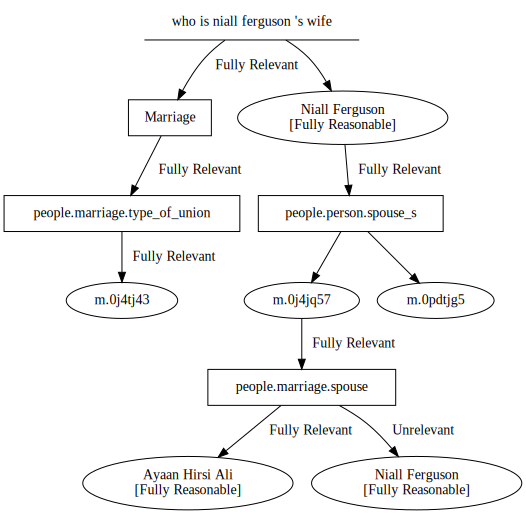

In [34]:
build_tree(queues[0])
# utility_score = queues[1]['verbose'][0]['utility']
visualize_tree(build_tree(queues[0]), queues[0]['verbose'] ,  'test')

In [15]:
precisions = []
recalls = []
f1s = []
hitss = []
for index in range(27, len(test_res)):
    true_index = test_res[index]['index']
    labels = [get_label(ans) if ans.startswith('m.') else ans for ans in test_data[true_index]['answer']]
    # labels = [get_label(ans['answer_argument']) if ans['answer_argument'].startswith('m.') else ans['answer_argument'] for ans in test_data[index]['answer']]
    prediction_tree = test_res[index]['tree']
    end_nodes = []
    for n_ind, node in prediction_tree.items():
        if 'Answer' in node['processed_pred']:
            end_nodes.append(n_ind)
    queues = []
    context_pattern = r'(.+?)\[(.*?)\]'
    for n_ind in end_nodes:
        queue = []
        node = prediction_tree[str(n_ind)]
        answer = node['processed_pred'].split('Answer:')[-1]
        if 'verbose' in node:
            # score = node['verbose']['seq_score']
            score =  node['score'] + 0.5 * (node['verbose']['utility_score']+ 1) 
        else:
            score = node['score']
        while node:
            parent = node['parent']
            if 'verbose' in node:
                queue.append(node['verbose'])
            if parent == None:
                queues.append({'verbose': queue, "answer": answer, "score": score})

                break
            node = prediction_tree[str(parent)]
    queues.sort(key=lambda x: x['score'], reverse=True)
    answers = set()
    for q in queues[:3]:
        answer = q['answer']
        candidate =  answer.strip().split(';')
        answers.update([re.findall(context_pattern, candidate[i])[0][0]  for i in range(len(candidate)) if len(re.findall(context_pattern, candidate[i]))])

    precision, recall, f1, hits =cal_eval_metric(list(answers), labels)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    hitss.append(hits)
    break